<a href="https://colab.research.google.com/github/Followb1ind1y/Semantic-Segmentation-of-Aerial-Imagery/blob/main/Semantic_Segmentation_of_Aerial_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Semantic Segmentation of Aerial Imagery**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import cv2

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## **Create Patches from the Original Dataset**

In [3]:
import os
import cv2
import math

from pathlib import Path
from torchvision import transforms

def create_patches(image_dir, patch_size, target_dir):
    target_dir_path = Path(target_dir)
    target_imgs_path, target_masks_path = Path(target_dir+'/'+'imgs/'), Path(target_dir+'/'+'masks/')
    #target_encoded_path = Path(target_dir+'/'+'encoded_masks/')
    target_dir_path.mkdir(parents=True, exist_ok=True)
    target_imgs_path.mkdir(parents=True, exist_ok=True)
    target_masks_path.mkdir(parents=True, exist_ok=True)
    #target_encoded_path.mkdir(parents=True, exist_ok=True)

    images_index, masks_index = 0, 0

    for path, _, _ in sorted(os.walk(image_dir)):
        dirname = path.split(os.path.sep)[-1]
        if dirname == 'images':
            images = sorted(os.listdir(path))
            for _, image_name in enumerate(images):
                if image_name.endswith(".jpg"):
                    #image = cv2.cvtColor(cv2.imread(path+"/"+image_name), cv2.COLOR_BGR2RGB)
                    image = cv2.imread(path+"/"+image_name)
                    size_X, size_Y = math.ceil(image.shape[1]/patch_size), math.ceil(image.shape[0]/patch_size)
                    pad_X, pad_Y = (patch_size * size_X - image.shape[1]) / (size_X - 1), (patch_size * size_Y - image.shape[0]) / (size_Y - 1)
                    image = Image.fromarray(image)
                    top = 0
                    for _ in range(size_Y):
                        left = 0
                        for _ in range(size_X):
                            crop_image = transforms.functional.crop(image, top, left, patch_size, patch_size)
                            crop_image = np.array(crop_image)
                            cv2.imwrite(f"{target_imgs_path}/image"+str(images_index).zfill(4)+".jpg", crop_image)
                            images_index += 1
                            left = left + patch_size - pad_X
                        top = top + patch_size - pad_Y
        
        if dirname == 'masks':
            images = sorted(os.listdir(path))
            for _, image_name in enumerate(images):
                if image_name.endswith(".png"):
                    #image = cv2.cvtColor(cv2.imread(path+"/"+image_name), cv2.COLOR_BGR2RGB)
                    image = cv2.imread(path+"/"+image_name)
                    size_X, size_Y = math.ceil(image.shape[1]/patch_size), math.ceil(image.shape[0]/patch_size)
                    pad_X, pad_Y = (patch_size * size_X - image.shape[1]) / (size_X - 1), (patch_size * size_Y - image.shape[0]) / (size_Y - 1)
                    image = Image.fromarray(image)
                    top = 0
                    for _ in range(size_Y):
                        left = 0
                        for _ in range(size_X):
                            crop_image = transforms.functional.crop(image, top, left, patch_size, patch_size)
                            crop_image = np.array(crop_image)
                            cv2.imwrite(f"{target_masks_path}/image"+str(masks_index).zfill(4)+".png", crop_image)
                            #encoded_image = one_hot_encode_masks(crop_image, 6)
                            #cv2.imwrite(f"{target_encoded_path}/image"+str(masks_index).zfill(4)+".png", encoded_image)
                            masks_index += 1
                            left = left + patch_size - pad_X
                        top = top + patch_size - pad_Y

In [4]:
orig_dir = '/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/content'
patch_size = 224

create_patches(image_dir=orig_dir, patch_size=patch_size, target_dir='dataset_patches')

In [5]:
# helper function for image visualization
def display(**images):
    """
    Plot images in one rown
    """
    num_images = len(images)
    plt.figure(figsize=(12,12))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

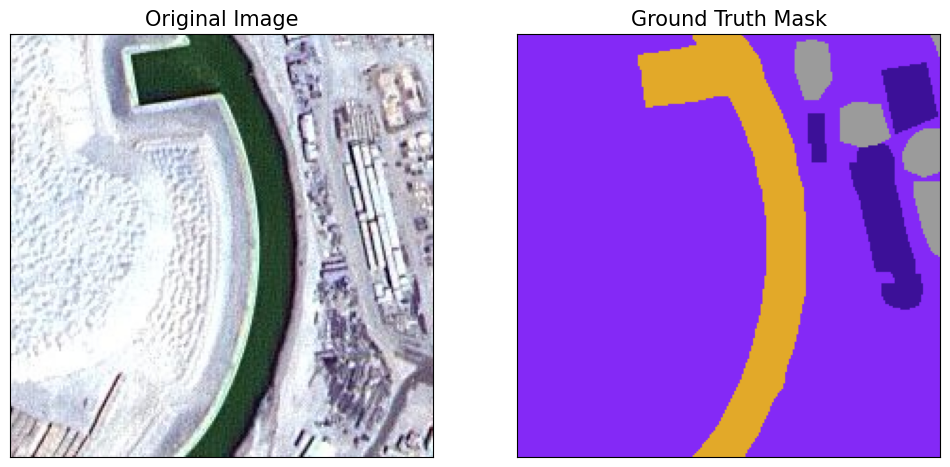

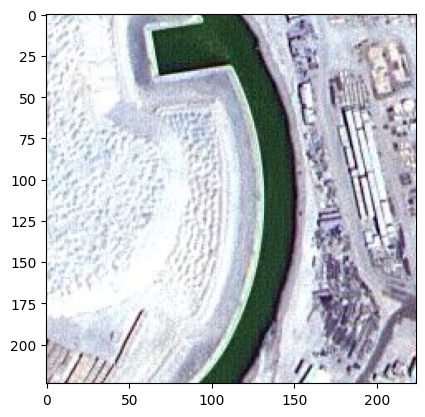

In [19]:
import skimage.io
original_image = skimage.io.imread('/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/dataset_patches/imgs/image0000.jpg')
ground_truth_mask = skimage.io.imread('/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/dataset_patches/masks/image0000.png')
display(original_image=original_image, ground_truth_mask=ground_truth_mask)
plt.imshow(original_image)

## **One-hot Encode for Masks**

In [8]:
import splitfolders

data_dir = '/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/dataset_patches'
name = 'dataset_split'
splitfolders.ratio(data_dir, output=name, seed=42, ratio=(0.8, 0.1, 0.1))
output_dir = '/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/dataset_split'

Copying files: 4662 files [00:00, 19196.84 files/s]


| Class Name | Color Hex # | Color RGB |
|--|--|--|
|Water|E2A929|(80, 227, 194)|
|Land (unpaved area)|8429F6|(132, 41, 246)|
|Road|6EC1E4|(110, 193, 228)|
|Building|3C1098|(60, 16, 152)|
|Vegetation|FEDD3A|(254, 221, 58)|
|Unlabeled|9B9B9B|(226, 169, 41)|


In [9]:
from enum import Enum

# mask color codes
class MaskColorMap(Enum):
    Unlabelled = (155, 155, 155)
    Building = (60, 16, 152)
    Land = (132, 41, 246)
    Road = (110, 193, 228)
    Vegetation = (254, 221, 58)
    Water = (226, 169, 41)

In [10]:
def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset 
    :param num_classes: number of classes
    :return: 
    """

    img_height, img_width, img_channels = masks.shape

        # create new mask of zeros
    encoded_image = np.zeros((img_height, img_width, 1)).astype(int)

    for j, cls in enumerate(MaskColorMap):
        encoded_image[np.all(masks == cls.value, axis=-1)] = j

    # return one-hot encoded labels
    encoded_image = np.reshape(np.eye(num_classes, dtype=int)[encoded_image],(224,224,6))

    return encoded_image

## **Image Augmentation**

In [11]:
# Calculate means and stds of the trainset and normalize

train_data = torchvision.datasets.ImageFolder(root = output_dir+'/train', transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5480, 0.4389, 0.6292])
Calculated stds: tensor([0.1554, 0.1918, 0.1756])


In [12]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

data_augmentation = {
    'train': A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=means, std=stds),
    ]),
    'val': A.Compose([
        A.Normalize(mean=means, std=stds),
    ]),
    'test': A.Compose([
        A.Normalize(mean=means, std=stds),
    ]),
}

/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/venv/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
import torch

from skimage.io import imread

class SemanticSegmentationDataset(torch.utils.data.Dataset):
    """Semantic Segmentation Dataset"""

    def __init__(self, image_dir, mask_dir, image_names, mask_names, transform=None, mask_transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            mask_dir (string): Directory with all the masks.
            image_names (list): List of image names.
            mask_names (list): List of mask names.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = image_names
        self.mask_names = mask_names
        self.transform = transform
        self.mask_transform = mask_transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])

        image = imread(img_name)
        mask = imread(mask_name)

        # One-hot encoding
        mask = one_hot_encode_masks(mask, 6)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        tenn = transforms.ToTensor()
        image = tenn(image)
        mask = tenn(mask)
        
        return image, mask

In [20]:
import os

Batch_Size = 16
image_datasets = {x: SemanticSegmentationDataset(image_dir=os.path.join(output_dir, x, 'imgs'),
                                                 mask_dir=os.path.join(output_dir, x, 'masks'), 
                                                 image_names=sorted(os.listdir(os.path.join(output_dir, x, 'imgs'))),
                                                 mask_names=sorted(os.listdir(os.path.join(output_dir, x, 'masks'))),
                                                 transform=None) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True, 
                                              drop_last=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda', index=0)

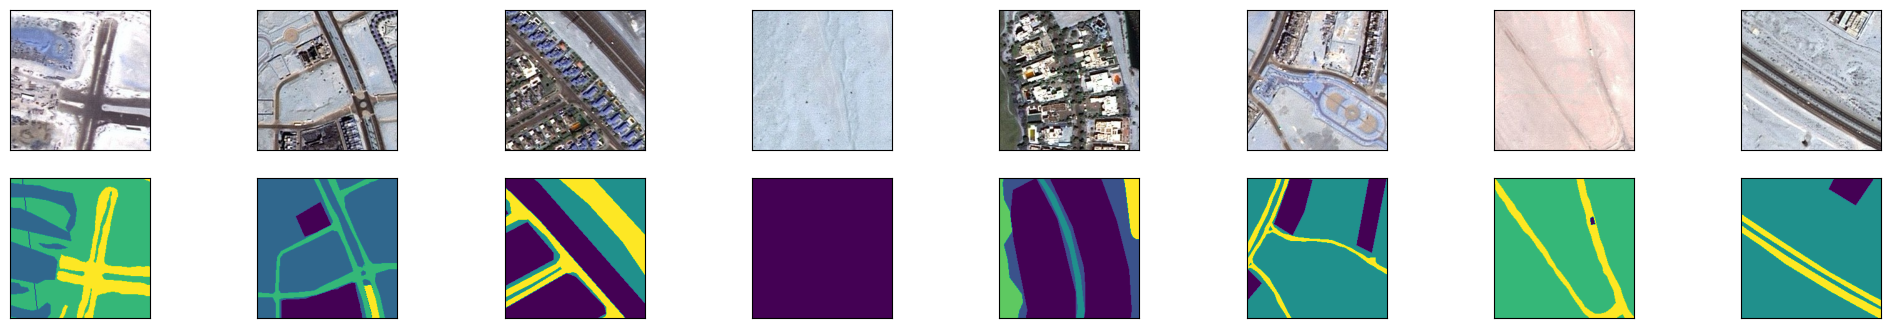

In [22]:
# Visualize some sample data from the original dataset

images, masks = next(iter(dataloaders['test']))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]))
    ax = fig.add_subplot(2, 8, 8+idx+1, xticks=[], yticks=[])
    reverse_encoded = np.transpose(np.argmax(masks[idx], axis=0, keepdims=True))
    plt.imshow(reverse_encoded)

## **Model Loading**

In [23]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=6, 
    activation=ACTIVATION,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /home/user/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 74.4M/74.4M [00:06<00:00, 11.7MB/s]


In [25]:
from torchinfo import summary

summary(model, 
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                                                       [16, 3, 224, 224]    [16, 6, 224, 224]    --                   True
├─EfficientNetEncoder (encoder)                                   [16, 3, 224, 224]    [16, 3, 224, 224]    806,400              True
│    └─Conv2dStaticSamePadding (_conv_stem)                       [16, 3, 224, 224]    [16, 48, 112, 112]   1,296                True
│    │    └─ZeroPad2d (static_padding)                            [16, 3, 224, 224]    [16, 3, 225, 225]    --                   --
│    └─BatchNorm2d (_bn0)                                         [16, 48, 112, 112]   [16, 48, 112, 112]   96                   True
│    └─MemoryEfficientSwish (_swish)                              [16, 48, 112, 112]   [16, 48, 112, 112]   --                   --
│    └─ModuleList (_blocks)                                  

## **Training Model**

In [26]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path

# Save the model to the target dir
def save_model(model: torch.nn.Module, target_dir: str, epoch: int):
    """
    Saves a PyTorch model to a target directory.
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    check_point_name = f"model_epoch_{epoch}"
    model_save_path = target_dir_path / check_point_name

    # Save the model state_dict()
    #print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

# Plot the training curve
def plot_curve(results: dict, epochs: int):
    train_ious, val_ious = np.array(results["train_iou"]), np.array(results["val_iou"])
    train_losses, val_losses = np.array(results["train_loss"]), np.array(results["val_loss"])

    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(epochs, step=1), train_ious, label='Train IoU')
    plt.plot(np.arange(epochs, step=1), val_losses, label='Val loss')
    plt.plot(np.arange(epochs, step=1), val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
# Categorical Cross Entropy Loss
class CategoricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_hat, y):
        return F.nll_loss(y_hat.log(), y.argmax(dim=1))

# Multiclass Dice Loss
class MultiDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def dice_coef(self, y_pred, y_true, smooth=0.0001):

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = torch.sum(y_true_f * y_pred_f)

        return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

    def dice_coef_multiclass(self, y_pred, y_true, numLabels=6, smooth=0.0001):    
        dice=0

        for index in range(numLabels):
            dice += self.dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:], smooth = 0.0001)

        return 1 - dice/numLabels

    def forward(self, y_pred, y_true):
        #return self.dice_coef_multiclass(torch.softmax(y_pred, dim=1), y_true)
        return self.dice_coef_multiclass(y_pred, y_true)

# Mean IoU Score
class MeanIoU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def IoU_coef(self, y_pred, y_true, smooth=0.0001): 

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = torch.sum(y_true_f * y_pred_f) 
        total = torch.sum(y_true_f + y_pred_f)
        union = total - intersection 
        
        return (intersection + smooth)/(union + smooth)

    def Mean_IoU(self, y_pred, y_true, numLabels=6, smooth=0.0001):
        IoU_Score=0

        for index in range(numLabels):
            IoU_Score += self.IoU_coef(y_true[:,index,:,:], y_pred[:,index,:,:], smooth = 1)

        return IoU_Score/numLabels

    def forward(self, y_pred, y_true):
        #return self.Mean_IoU(torch.softmax(y_pred, dim=1), y_true)
        return self.Mean_IoU(y_pred, y_true)

# helper function for image visualization
def display(**images):
    """
    Plot images in one row
    """
    # clear_output(wait=True)
    num_images = len(images)
    plt.figure(figsize=(12,12))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

In [27]:
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
import time
import numpy as np

from tqdm.auto import tqdm
from tqdm import tqdm, trange

class Trainer:
    def __init__(self, 
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.Dataset,
                 epochs: int, 
                 metric: torch.nn.Module, 
                 criterion: torch.nn.Module, 
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device):
        
        self.model = model
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.epoch = 0
        self.epochs = epochs
        self.metric = metric
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device

        # Create empty results dictionary
        self.results = {"train_loss": [],
                        "train_iou": [],
                        "val_loss": [],
                        "val_iou": []
                        }
        
    def train_model(self):
        """
        Train the Model.
        """
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for i in progressbar:
            # Epoch counter
            self.epoch += 1
            #progressbar.set_description(f"Epoch {self.epoch}")

            # Training block
            self.train_epoch()
            #progressbar.set_description(f'\nTrain loss: {self.results["train_loss"][-1]} Train iou: {self.results["train_iou"][-1]}')

            # Validation block
            self.val_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]} Train iou: {self.results["train_iou"][-1]} Val loss: {self.results["val_loss"][-1]} Val iou: {self.results["val_iou"][-1]}')

            # Save checkpoints every epoch
            save_model(self.model, self.save_dir, self.epoch)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # plot training curve
        plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        """
        Training Mode
        """
        self.model.train() # training mode
        running_ious, running_losses = [], []

        for x, y in self.train_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward - track history if only in train
            outputs = self.model(inputs)
            # Calculate the loss
            loss = self.criterion(outputs, targets)
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Calculate the iou
            iou = self.metric(outputs, targets)
            iou_value = iou.item()
            running_ious.append(iou_value)

            # Backward pass
            loss.backward()
            # Update the parameters
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))
        self.results["train_iou"].append(np.mean(running_ious))

    def val_epoch(self):
        """
        Validation Mode
        """
        self.model.eval() # Validation mode
        running_ious, running_losses = [], []

        for x, y in self.val_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                # Calculate the loss
                loss = self.criterion(outputs, targets)
                loss_value = loss.item()
                running_losses.append(loss_value)

                # Calculate the iou
                iou = self.metric(outputs, targets)
                iou_value = iou.item()
                running_ious.append(iou_value)

        self.results["val_loss"].append(np.mean(running_losses))
        self.results["val_iou"].append(np.mean(running_ious))

In [28]:
# Find the test iou of a target model
def evaluate_model(model: torch.nn.Module, 
                   dataloaders: torch.utils.data.DataLoader,
                   metric: torch.nn.Module, 
                   criterion: torch.nn.Module, 
                   device: torch.device):
    """
    Evaluate model performance on testset
    """
    model.eval()
    model.to(device)

    running_ious, running_losses = [], []

    for x, y in dataloaders:
    # Send to device (GPU or CPU)
        inputs = x.to(device)
        targets = y.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Calculate the iou
            iou = metric(outputs, targets)
            iou_value = iou.item()
            running_ious.append(iou_value)
    
    mean_loss = np.mean(running_losses)
    mean_metric = np.mean(running_ious)
        
    return mean_loss, mean_metric

# Predict the masks
def predict_mask(img: torch.Tensor, 
            model: torch.nn.Module, 
            device: str):

    model.eval()
    model.to(device)

    x = img.to(device)
    with torch.no_grad():
        out = model(x)

    result = torch.softmax(out, dim=1)

    return result

Progress:   3%|███                                                                                       | 1/30 [00:30<14:32, 30.07s/it]


Epoch 1: Train loss: 0.43461656364901313 Train iou: 0.4512728822642359 Val loss: 0.787238883120673 Val iou: 0.14876896515488625


Progress:   7%|██████                                                                                    | 2/30 [01:00<14:04, 30.15s/it]


Epoch 2: Train loss: 0.34176826065984267 Train iou: 0.5532835290349764 Val loss: 0.43015200325420927 Val iou: 0.44828031744275776


Progress:  10%|█████████                                                                                 | 3/30 [01:31<13:42, 30.48s/it]


Epoch 3: Train loss: 0.31728860427593364 Train iou: 0.5795852377496916 Val loss: 0.3728587712560381 Val iou: 0.5131958574056625


Progress:  13%|████████████                                                                              | 4/30 [02:01<13:15, 30.60s/it]


Epoch 4: Train loss: 0.3091600460225138 Train iou: 0.5892877460553728 Val loss: 0.34184615101133076 Val iou: 0.5536502322980336


Progress:  17%|███████████████                                                                           | 5/30 [02:31<12:39, 30.39s/it]


Epoch 5: Train loss: 0.3028242428754938 Train iou: 0.5946474594288859 Val loss: 0.3285168877669743 Val iou: 0.5641119352408818


Progress:  20%|██████████████████                                                                        | 6/30 [03:01<12:03, 30.16s/it]


Epoch 6: Train loss: 0.2902363970361907 Train iou: 0.6080492799138201 Val loss: 0.351526928799493 Val iou: 0.5343545973300934


Progress:  23%|█████████████████████                                                                     | 7/30 [03:31<11:34, 30.21s/it]


Epoch 7: Train loss: 0.2879295364536088 Train iou: 0.6096574915894146 Val loss: 0.28551386509622845 Val iou: 0.6061133486883981


Progress:  27%|████████████████████████                                                                  | 8/30 [04:05<11:26, 31.20s/it]


Epoch 8: Train loss: 0.2609682124236534 Train iou: 0.6370529116227709 Val loss: 0.2758972389357431 Val iou: 0.6242075221879142


Progress:  30%|███████████████████████████                                                               | 9/30 [04:36<10:56, 31.26s/it]


Epoch 9: Train loss: 0.2519469327967742 Train iou: 0.6463763790911642 Val loss: 0.2605240983622415 Val iou: 0.6341288813522884


Progress:  33%|█████████████████████████████▋                                                           | 10/30 [05:08<10:28, 31.43s/it]


Epoch 10: Train loss: 0.2558103404168425 Train iou: 0.6416792866998705 Val loss: 0.2607776480061667 Val iou: 0.6356344521045685


Progress:  37%|████████████████████████████████▋                                                        | 11/30 [05:39<09:54, 31.32s/it]


Epoch 11: Train loss: 0.23054533220570664 Train iou: 0.6680504905766455 Val loss: 0.25017036710466656 Val iou: 0.6464228757790157


Progress:  40%|███████████████████████████████████▌                                                     | 12/30 [06:10<09:20, 31.14s/it]


Epoch 12: Train loss: 0.23077462510815983 Train iou: 0.6703579107235218 Val loss: 0.27244930607931955 Val iou: 0.6273780635425023


Progress:  43%|██████████████████████████████████████▌                                                  | 13/30 [06:42<08:54, 31.43s/it]


Epoch 13: Train loss: 0.22278769571205664 Train iou: 0.6760362792631676 Val loss: 0.26589443002428326 Val iou: 0.6340301930904388


Progress:  47%|█████████████████████████████████████████▌                                               | 14/30 [07:13<08:21, 31.37s/it]


Epoch 14: Train loss: 0.22276238172218718 Train iou: 0.6779769946788919 Val loss: 0.2680322527885437 Val iou: 0.6308583574635642


Progress:  50%|████████████████████████████████████████████▌                                            | 15/30 [07:44<07:46, 31.08s/it]


Epoch 15: Train loss: 0.22364541888237 Train iou: 0.6779294985121694 Val loss: 0.2595936826297215 Val iou: 0.6386487654277256


Progress:  53%|███████████████████████████████████████████████▍                                         | 16/30 [08:14<07:13, 30.98s/it]


Epoch 16: Train loss: 0.21574462693313073 Train iou: 0.6857405412813713 Val loss: 0.2582331470080784 Val iou: 0.6382273989064353


Progress:  57%|██████████████████████████████████████████████████▍                                      | 17/30 [08:45<06:43, 31.03s/it]


Epoch 17: Train loss: 0.21829474537537016 Train iou: 0.6834271575870186 Val loss: 0.2545753674847739 Val iou: 0.6438647423471723


Progress:  60%|█████████████████████████████████████████████████████▍                                   | 18/30 [09:16<06:10, 30.83s/it]


Epoch 18: Train loss: 0.21830213069915771 Train iou: 0.6826070331293961 Val loss: 0.25649409208978924 Val iou: 0.640248681817736


Progress:  63%|████████████████████████████████████████████████████████▎                                | 19/30 [09:48<05:43, 31.19s/it]


Epoch 19: Train loss: 0.21528099014841276 Train iou: 0.6865654572330672 Val loss: 0.2660915766443525 Val iou: 0.633597310100283


Progress:  67%|███████████████████████████████████████████████████████████▎                             | 20/30 [10:18<05:10, 31.01s/it]


Epoch 20: Train loss: 0.21142728164278227 Train iou: 0.688004078536198 Val loss: 0.2617924085685185 Val iou: 0.6373321967465537


Progress:  70%|██████████████████████████████████████████████████████████████▎                          | 21/30 [10:50<04:39, 31.09s/it]


Epoch 21: Train loss: 0.21685882169624854 Train iou: 0.6845174185160933 Val loss: 0.25595895307404654 Val iou: 0.6413227191993168


Progress:  73%|█████████████████████████████████████████████████████████████████▎                       | 22/30 [11:21<04:08, 31.12s/it]


Epoch 22: Train loss: 0.20745421843282108 Train iou: 0.6937893048442644 Val loss: 0.27084544726780485 Val iou: 0.6291115581989288


Progress:  77%|████████████████████████████████████████████████████████████████████▏                    | 23/30 [11:54<03:42, 31.84s/it]


Epoch 23: Train loss: 0.21609633390245767 Train iou: 0.6859526834611235 Val loss: 0.25440723981176105 Val iou: 0.6453699682440076


Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 24/30 [12:27<03:13, 32.19s/it]


Epoch 24: Train loss: 0.21231171797061787 Train iou: 0.6880733247460991 Val loss: 0.24462479778698512 Val iou: 0.6506065172808511


Progress:  83%|██████████████████████████████████████████████████████████████████████████▏              | 25/30 [12:59<02:40, 32.02s/it]


Epoch 25: Train loss: 0.21183282856283517 Train iou: 0.6891181181217062 Val loss: 0.2677728661469051 Val iou: 0.6315651493413108


Progress:  87%|█████████████████████████████████████████████████████████████████████████████▏           | 26/30 [13:30<02:06, 31.64s/it]


Epoch 26: Train loss: 0.21217753866623187 Train iou: 0.6894174839915901 Val loss: 0.2610279364245279 Val iou: 0.6384146937302181


Progress:  90%|████████████████████████████████████████████████████████████████████████████████         | 27/30 [14:01<01:34, 31.51s/it]


Epoch 27: Train loss: 0.21240189774283047 Train iou: 0.6877491987984756 Val loss: 0.2634980423109872 Val iou: 0.6384208585534777


Progress:  93%|███████████████████████████████████████████████████████████████████████████████████      | 28/30 [14:32<01:02, 31.31s/it]


Epoch 28: Train loss: 0.20912780278715595 Train iou: 0.6924275252325781 Val loss: 0.2532844543457031 Val iou: 0.6446294188499451


Progress:  97%|██████████████████████████████████████████████████████████████████████████████████████   | 29/30 [15:03<00:31, 31.12s/it]


Epoch 29: Train loss: 0.20934636428438383 Train iou: 0.6912050791855516 Val loss: 0.2600532685007368 Val iou: 0.6389243049280984


Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 30/30 [15:33<00:00, 31.13s/it]


Epoch 30: Train loss: 0.2082450096977168 Train iou: 0.6916858615546391 Val loss: 0.2785785581384386 Val iou: 0.6208736385617938


--------------------
Training complete in 15m 34s


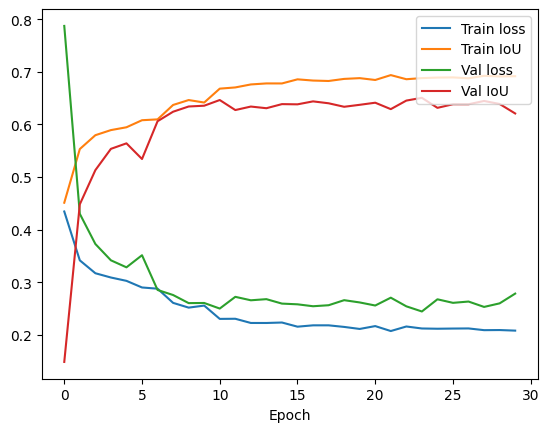

In [29]:
## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
model = model.to(device)
metric_UNet = MeanIoU()
criterion_UNet = MultiDiceLoss()
optimizer_UNet = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

# Trainer
trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=30,
                  metric=metric_UNet,
                  criterion=criterion_UNet, 
                  optimizer=optimizer_UNet,
                  scheduler=exp_lr_scheduler_UNet,
                  save_dir="UNet_Model_Output",
                  device=device)

## Training process
model_results = trainer.train_model()

## **Evaluation on Testset**

In [30]:
model_state = torch.load('/home/user/repos/Semantic-Segmentation-of-Aerial-Imagery/UNet_Model_Output/model_epoch_30')
model.load_state_dict(model_state)

<All keys matched successfully>

In [31]:
## Model inItialization
model = model.to(device)
metric_DeepLab_V3 = MeanIoU()
criterion_DeepLab_V3 = MultiDiceLoss()
optimizer_DeepLab_V3 = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler_DeepLab_V3 = lr_scheduler.StepLR(optimizer_DeepLab_V3, step_size=7, gamma=0.1)

In [32]:
outputs = evaluate_model(model=model, dataloaders=dataloaders['val'], 
                           metric=metric_DeepLab_V3, criterion=criterion_DeepLab_V3,
                           device=device)

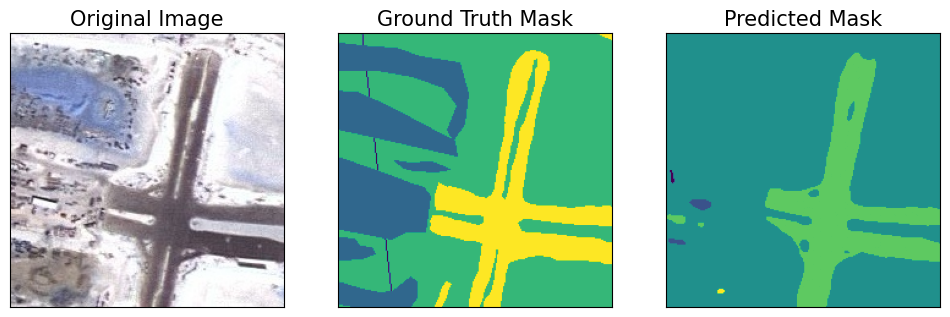

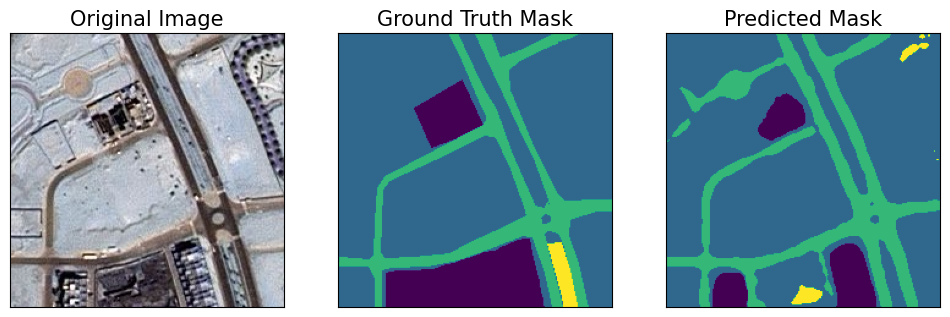

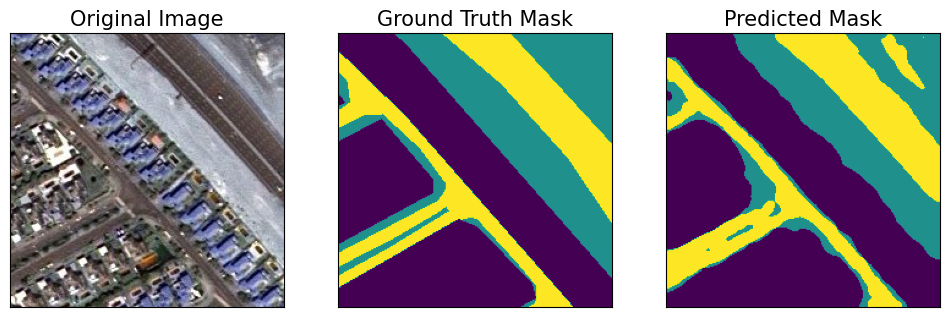

In [33]:
for idx in range(3):
    original_image = np.transpose(images[idx])
    ground_truth_mask = np.transpose(np.argmax(masks[idx], axis=0, keepdims=True))
    res = predict_mask(img=images, model=model, device=device)
    predicted_mask = np.transpose(np.argmax(res[idx].to('cpu'), axis=0, keepdims=True))
    display(original_image=original_image, ground_truth_mask=ground_truth_mask, predicted_mask=predicted_mask)